In [1]:
import json
from pprint import pprint
import os
import re

from datasets import load_dataset

In [2]:
def extract_patch_file_path(patch_str):
    """Extract the file path that was patched from the diff."""
    match = re.search(r"^diff --git a/(.*?) b/\1", patch_str, re.MULTILINE)
    if match:
        return match.group(1)
    fallback = re.search(r"^\+\+\+ b/(.+)", patch_str, re.MULTILINE)
    if fallback:
        return fallback.group(1)
    return None

In [3]:
swebench_dataset = load_dataset("princeton-nlp/SWE-bench_Lite", split="test")

In [4]:
def get_swebench_data_by_id(instance_id):
    for data in swebench_dataset:
        if data["instance_id"] == instance_id:
            return data
    return None

In [10]:
prediction_1 = "/local/home/amamun/projects/RAGent/repair_results/run_1/ragent/ragent_majority_voting_and_regression_and_reproduction_evaluation.json"

In [11]:
with open(prediction_1, "r") as f:
    predictions_data_1 = json.load(f)

In [12]:
patch_data = "/local/home/amamun/projects/RAGent/repair_results/run_1/ragent/patches/ragent_majority_voting_and_regression_and_reproduction.jsonl"

with open(patch_data, "r") as f:
    patch_lines = f.readlines()
patch_data_list = [json.loads(line) for line in patch_lines]

In [13]:
print(len(patch_data_list))

300


In [14]:
localization_data = "/local/home/amamun/projects/RAGent/repair_results/ragent_locs.jsonl"

with open(localization_data, "r") as f:
    loc_lines = f.readlines()
loc_data_list = [json.loads(line) for line in loc_lines]

In [15]:
print(len(loc_data_list))

300


In [16]:
correctly_localized_ids = []

for loc_data in loc_data_list:
    if loc_data["patch_file"] in loc_data["found_files"][:3]:
        correctly_localized_ids.append(loc_data["instance_id"])

In [17]:
print("Correctly localized at line level:", len(correctly_localized_ids))

Correctly localized at line level: 259


In [18]:
total_resolved = len(predictions_data_1["resolved_ids"])

In [19]:
len(correctly_localized_ids)

259

In [20]:
with open(prediction_1, "r") as f:
    ragfix_prediction_data = json.load(f)

In [21]:
def get_patch_by_id(patch_id):
    for patch in patch_data_list:
        if patch["instance_id"] == patch_id:
            return patch
    return None

In [22]:
def get_ground_truth_patch_by_id(patch_id):
    swebench_data = get_swebench_data_by_id(patch_id)
    if swebench_data:
        return swebench_data["patch"]
    return None

In [23]:
len(ragfix_prediction_data["resolved_ids"])

100

In [24]:
unresolved_ids = ragfix_prediction_data["unresolved_ids"]
empty_patches = ragfix_prediction_data["empty_patch_ids"]

total_unresolved = len(unresolved_ids)
correctly_localized_yet_unresolved_ids = [uid for uid in unresolved_ids if uid in correctly_localized_ids]

print("Total unresolved IDs:", total_unresolved)
print("Total empty patches:", len(empty_patches))
print("Correctly localized yet unresolved IDs:", correctly_localized_yet_unresolved_ids)

Total unresolved IDs: 178
Total empty patches: 22
Correctly localized yet unresolved IDs: ['astropy__astropy-14182', 'astropy__astropy-14365', 'astropy__astropy-7746', 'django__django-11019', 'django__django-11133', 'django__django-11283', 'django__django-11422', 'django__django-11620', 'django__django-11630', 'django__django-11742', 'django__django-11905', 'django__django-11910', 'django__django-11964', 'django__django-11999', 'django__django-12113', 'django__django-12125', 'django__django-12184', 'django__django-12284', 'django__django-12286', 'django__django-12308', 'django__django-12700', 'django__django-12747', 'django__django-13033', 'django__django-13220', 'django__django-13265', 'django__django-13321', 'django__django-13401', 'django__django-13448', 'django__django-13551', 'django__django-13660', 'django__django-13768', 'django__django-14155', 'django__django-14534', 'django__django-14608', 'django__django-14667', 'django__django-14730', 'django__django-14787', 'django__django-

In [25]:
could_not_localize_at_file_level = total_unresolved - len(correctly_localized_yet_unresolved_ids)

In [26]:
len(correctly_localized_yet_unresolved_ids), could_not_localize_at_file_level

(146, 32)

In [27]:
ragfix_function_level_data = "/local/home/amamun/projects/RAGent/repair_results/ragent_locs_function_level.jsonl"
with open(ragfix_function_level_data, "r") as f:
    func_loc_lines = f.readlines()
func_loc_data_list = [json.loads(line) for line in func_loc_lines]

def get_function_level_loc_by_id(instance_id):
    for data in func_loc_data_list:
        if data["instance_id"] == instance_id:
            return data["found_related_locs"]
    return None

In [28]:
gt_function_level = "/local/home/amamun/projects/RAGent/repair_results/swebench_function_level_gt_loc.json"
with open(gt_function_level, "r") as f:
    gt_function_level_data = json.load(f)

In [29]:
def construct_pred_func(func_locs):
    final_funcs = []
    for key, item in func_locs.items():
        final_funcs.append(item)
    return final_funcs

In [30]:
def parse_gt_methods(gt_entries):
    files, methods = set(), set()

    for entry in gt_entries:
        parts = entry.split('::')

        if len(parts) == 2:  # File::Method 或 File::Class
            file_name, method_or_class = parts
            files.add(file_name)
            methods.add(method_or_class)

        elif len(parts) == 1:  # File
            files.add(parts[0])

    return files, methods

In [31]:
def extract_predicted_methods(found_related_locs):
    predicted_methods = []
    for sublist in found_related_locs:
        # print(sublist)
        for loc in sublist:
            for entry in loc.split('\n'):
                if 'function:' in entry or 'class:' in entry:
                    try:                        
                        predicted_methods.append(entry.split(': ')[1])
                    except:
                        pass
    return predicted_methods

In [32]:
get_function_level_loc_by_id("pallets__flask-5063")

{'src/flask/cli.py': ['function: routes_command'],
 'src/flask/app.py': [''],
 'src/flask/blueprints.py': ['']}

In [33]:
extract_predicted_methods(construct_pred_func(get_function_level_loc_by_id("astropy__astropy-14182")))

[]

In [34]:
total_incorrectly_predicted_instances_at_function_level = 0
incorrect_function_level_predictions = {}


for uid in correctly_localized_yet_unresolved_ids:
    patch_info = get_patch_by_id(uid)
    gt_files, gt_methods = parse_gt_methods(gt_function_level_data.get(uid, []))
    predicted_methods = extract_predicted_methods(construct_pred_func(get_function_level_loc_by_id(uid)))

    predicted_method_in_gt = any(pm in gt_methods for pm in predicted_methods[:3])

    if not predicted_method_in_gt:
        total_incorrectly_predicted_instances_at_function_level += 1
        incorrect_function_level_predictions[uid] = {
            "ground_truth": gt_methods,
            "predicted": predicted_methods
        }

print(f"Total incorrectly method predicted instances: {total_incorrectly_predicted_instances_at_function_level} out of {len(correctly_localized_yet_unresolved_ids)}")


Total incorrectly method predicted instances: 68 out of 146


In [35]:
gt_function_level_data["pallets__flask-5063"]

['src/flask/cli.py::routes_command']

In [36]:
incorrect_function_level_predictions

{'astropy__astropy-14182': {'ground_truth': {'RST.__init__',
   'RST.write',
   'get_fixedwidth_params'},
  'predicted': []},
 'django__django-11019': {'ground_truth': {'Media._css',
   'Media._js',
   'Media.merge'},
  'predicted': []},
 'django__django-11133': {'ground_truth': {'HttpResponseBase.make_bytes'},
  'predicted': []},
 'django__django-11422': {'ground_truth': {'iter_modules_and_files'},
  'predicted': ['iter_all_python_module_files',
   'get_reloader',
   'run_with_reloader',
   'start_django',
   'restart_with_reloader',
   'trigger_reload',
   'BaseReloader.watch_file',
   'BaseReloader.watch_dir',
   'BaseReloader.watched_files',
   'StatReloader.snapshot_files']},
 'django__django-11620': {'ground_truth': {'technical_404_response'},
  'predicted': ['RoutePattern.match',
   'URLResolver.resolve',
   'response_for_exception',
   'get_exception_response',
   'handle_uncaught_exception',
   'technical_404_response']},
 'django__django-11905': {'ground_truth': {'IsNull.as_s

In [37]:
correctly_localized_at_function_level_ids = [uid for uid in correctly_localized_yet_unresolved_ids if uid not in incorrect_function_level_predictions]

In [38]:
len(correctly_localized_at_function_level_ids)

78

In [39]:
correctly_localized_at_function_level_ids

['astropy__astropy-14365',
 'astropy__astropy-7746',
 'django__django-11283',
 'django__django-11630',
 'django__django-11742',
 'django__django-11910',
 'django__django-12308',
 'django__django-12700',
 'django__django-13033',
 'django__django-13220',
 'django__django-13321',
 'django__django-13401',
 'django__django-13448',
 'django__django-13551',
 'django__django-13660',
 'django__django-13768',
 'django__django-14155',
 'django__django-14855',
 'django__django-14999',
 'django__django-15061',
 'django__django-15202',
 'django__django-15400',
 'django__django-15695',
 'django__django-15819',
 'django__django-15996',
 'django__django-16816',
 'matplotlib__matplotlib-22711',
 'matplotlib__matplotlib-22835',
 'matplotlib__matplotlib-23299',
 'matplotlib__matplotlib-23476',
 'matplotlib__matplotlib-23563',
 'matplotlib__matplotlib-24334',
 'matplotlib__matplotlib-25498',
 'mwaskom__seaborn-3407',
 'pallets__flask-4045',
 'pallets__flask-4992',
 'pallets__flask-5063',
 'psf__requests-19

In [40]:
def get_swe_data_index_by_id(instance_id):
    for idx, data in enumerate(swebench_dataset):
        if data["instance_id"] == instance_id:
            return idx
    return None

In [41]:
def get_code_text_from_path(node, path_parts):
    if len(path_parts) == 1:
        return "\n".join(node[path_parts[0]]["text"])

    return get_code_text_from_path(node[path_parts[0]], path_parts[1:])

In [42]:
repo_path_root = "/local/home/amamun/projects/RAGent/swebench_data"

In [43]:
def get_repo_data_by_id(instance_id):
    idx = get_swe_data_index_by_id(instance_id)
    repo_path = os.path.join(repo_path_root, f"swebench_{idx}_py.json")
    with open(repo_path, "r") as f:
        code_structure = json.load(f)
    return code_structure

In [44]:
import re
from difflib import SequenceMatcher
from unidiff import PatchSet

from unidiff import PatchSet

def extract_first_change(patch_str):
    """
    Extracts (file_path, first_changed_line_number, changed_line_text)
    from a unified diff string, ignoring Python comments and multi-line docstrings.
    """
    patch = PatchSet(patch_str)
    in_docstring = False
    
    for patched_file in patch:
        for hunk in patched_file:
            for line in hunk:
                if line.is_added or line.is_removed:
                    text = line.value.strip()
                    
                    # Handle multi-line docstrings
                    if in_docstring:
                        if text.endswith('"""') or text.endswith("'''"):
                            in_docstring = False
                        continue
                    
                    if text.startswith('"""') or text.startswith("'''"):
                        if not (text.endswith('"""') or text.endswith("'''") and len(text) > 3):
                            in_docstring = True
                        continue
                    
                    # Ignore single-line comments
                    if text.startswith("#"):
                        continue
                    
                    # Return first non-comment/non-docstring line
                    line_no = line.source_line_no if line.source_line_no is not None else line.target_line_no
                    return patched_file.path, line_no, text
    return None, None, None



def is_line_localization_error(gold_patch, model_patch, max_distance=10, buffer=5, sim_threshold=0.6):
    """
    Heuristic check for line-level localization error:
      - same file
      - first changed statements textually similar
      - line numbers within allowed distance
    """
    data = {}
    g_file, g_line, g_text = extract_first_change(gold_patch)
    m_file, m_line, m_text = extract_first_change(model_patch)

    print(f"Gold: file={g_file}, line={g_line}, text='{g_text}'")
    print(f"Model: file={m_file}, line={m_line}, text='{m_text}'")
    
    # Close lines, so not likely a localization error
    if abs(g_line - m_line) <= 5:
        return False
    
    sim = SequenceMatcher(None, g_text, m_text).ratio()
    print(f"Sequence similarity: {sim:.2f}")

    # Check if both changes are close & similar
    if abs(g_line - m_line) < max_distance and sim >= sim_threshold:
        return False
    
    # line difference is too large, so possibly a localization error
    if abs(g_line - m_line) > max_distance:
        return True

    return True

In [45]:
def check_line_level_issues(issue_id):
    print(f"Checking issue ID: {issue_id}")
    repo_data = get_repo_data_by_id(issue_id)
    patch_info = get_patch_by_id(issue_id)
    patch_file_path = extract_patch_file_path(patch_info["model_patch"])
    gold_patch = get_ground_truth_patch_by_id(issue_id)

    # print(f"Model Patch: {patch_info['model_patch']}")
    # print("-----------------")
    # print(f"Gold Patch: {gold_patch}")
    # source_code = get_code_text_from_path(repo_data, patch_file_path.split("/"))

    result = is_line_localization_error(gold_patch, patch_info["model_patch"], max_distance=10)

    print(result)

In [46]:
len(correctly_localized_at_function_level_ids)

78

In [47]:
correctly_localized_at_line_level_ids = []

for uid in correctly_localized_at_function_level_ids:
    repo_data = get_repo_data_by_id(uid)
    patch_info = get_patch_by_id(uid)
    patch_file_path = extract_patch_file_path(patch_info["model_patch"])
    gold_patch = get_ground_truth_patch_by_id(uid)

    source_code = get_code_text_from_path(repo_data, patch_file_path.split("/"))

    is_line_level_issue = is_line_localization_error(gold_patch, patch_info["model_patch"], max_distance=10, sim_threshold=0.5)
    print(f"Line level issue for ID {uid}: {is_line_level_issue}")
    print("===================================")

    if not is_line_level_issue:
        correctly_localized_at_line_level_ids.append(uid)

Gold: file=astropy/io/ascii/qdp.py, line=71, text='_line_type_re = re.compile(_type_re)'
Model: file=astropy/io/ascii/qdp.py, line=71, text='_line_type_re = re.compile(_type_re)'
Line level issue for ID astropy__astropy-14365: False
Gold: file=astropy/wcs/wcs.py, line=1215, text='if any([x.size == 0 for x in axes]):'
Model: file=astropy/wcs/wcs.py, line=1227, text='if xy.shape[0] == 0:'
Sequence similarity: 0.46
Line level issue for ID astropy__astropy-7746: True
Gold: file=django/contrib/auth/migrations/0011_update_proxy_permissions.py, line=1, text='from django.db import migrations'
Model: file=django/contrib/auth/migrations/0011_update_proxy_permissions.py, line=29, text='Permission.objects.filter('
Sequence similarity: 0.24
Line level issue for ID django__django-11283: True
Gold: file=django/core/checks/model_checks.py, line=7, text='from django.core.checks import Error, Tags, register'
Model: file=django/core/checks/model_checks.py, line=17, text='from django.db import router'
Seq

In [48]:
print(f"Total correctly localized at line level instances: {len(correctly_localized_at_line_level_ids)} out of {len(correctly_localized_at_function_level_ids)}")
total_incorrectly_predicted_instances_at_line_level = len(correctly_localized_at_function_level_ids) - len(correctly_localized_at_line_level_ids)
print(f"Total incorrectly localized at line level instances: {total_incorrectly_predicted_instances_at_line_level} out of {len(correctly_localized_at_function_level_ids)}")

Total correctly localized at line level instances: 32 out of 78
Total incorrectly localized at line level instances: 46 out of 78


In [49]:
incorrect_line_level_localizations = [uid for uid in correctly_localized_at_function_level_ids if uid not in correctly_localized_at_line_level_ids]

In [50]:
issue_failed_during_patch_gen = "django__django-11133"
    
print(get_patch_by_id(issue_failed_during_patch_gen)["model_patch"])
print("-----------------")
print(get_ground_truth_patch_by_id(issue_failed_during_patch_gen))

diff --git a/django/http/response.py b/django/http/response.py
index 5126111..4c43e18 100644
--- a/django/http/response.py
+++ b/django/http/response.py
@@ -309,7 +309,8 @@ class HttpResponse(HttpResponseBase):
     @content.setter
     def content(self, value):
         # Consume iterators upon assignment to allow repeated iteration.
-        if hasattr(value, '__iter__') and not isinstance(value, (bytes, str)):
+        # Treat memoryview objects as a single bytes-like value rather than an iterable of ints.
+        if hasattr(value, '__iter__') and not isinstance(value, (bytes, str, memoryview)):
             content = b''.join(self.make_bytes(chunk) for chunk in value)
             if hasattr(value, 'close'):
                 try:

-----------------
diff --git a/django/http/response.py b/django/http/response.py
--- a/django/http/response.py
+++ b/django/http/response.py
@@ -229,7 +229,7 @@ def make_bytes(self, value):
         # Handle string types -- we can't rely on force_bytes h

In [51]:
failure_stages_dict_when_localization_was_correct = {
    "total_unresolved": len(correctly_localized_yet_unresolved_ids),
    "failed_at_file_level_loc": len(swebench_dataset) - len(correctly_localized_ids),
    "failed_at_function_level_loc": total_incorrectly_predicted_instances_at_function_level,
    "failed_at_line_level_loc": total_incorrectly_predicted_instances_at_line_level,
    "failed_at_patch_generation": len(correctly_localized_at_line_level_ids),
}

In [52]:
correctly_localized_at_line_level_ids

['astropy__astropy-14365',
 'django__django-11910',
 'django__django-12308',
 'django__django-12700',
 'django__django-13401',
 'django__django-13660',
 'django__django-14855',
 'django__django-14999',
 'django__django-15061',
 'django__django-15695',
 'django__django-16816',
 'pallets__flask-4045',
 'pallets__flask-4992',
 'pylint-dev__pylint-6506',
 'pytest-dev__pytest-5103',
 'pytest-dev__pytest-6116',
 'pytest-dev__pytest-7168',
 'scikit-learn__scikit-learn-10508',
 'scikit-learn__scikit-learn-10949',
 'scikit-learn__scikit-learn-14087',
 'sphinx-doc__sphinx-10325',
 'sphinx-doc__sphinx-7738',
 'sphinx-doc__sphinx-8506',
 'sympy__sympy-14817',
 'sympy__sympy-16281',
 'sympy__sympy-16988',
 'sympy__sympy-17139',
 'sympy__sympy-19254',
 'sympy__sympy-19487',
 'sympy__sympy-21171',
 'sympy__sympy-22005',
 'sympy__sympy-24066']

In [53]:
correctly_localized_at_func_level_id = correctly_localized_at_line_level_ids[30]

print("Issue ID:", correctly_localized_at_func_level_id)
print(get_patch_by_id(correctly_localized_at_func_level_id)["model_patch"])
print("-----------------")
print(get_ground_truth_patch_by_id(correctly_localized_at_func_level_id))

Issue ID: sympy__sympy-22005
diff --git a/sympy/solvers/polysys.py b/sympy/solvers/polysys.py
index 66efb1a..8ab9101 100644
--- a/sympy/solvers/polysys.py
+++ b/sympy/solvers/polysys.py
@@ -240,7 +240,9 @@ def solve_generic(polys, opt):
 
         univariate = list(filter(_is_univariate, basis))
 
-        if len(univariate) == 1:
+        # Only accept a single univariate polynomial when the system has exactly one generator.
+        # This prevents treating underdetermined (infinite solution) systems as zero‑dimensional.
+        if len(univariate) == 1 and len(gens) == 1:
             f = univariate.pop()
         else:
             raise NotImplementedError(filldedent('''

-----------------
diff --git a/sympy/solvers/polysys.py b/sympy/solvers/polysys.py
--- a/sympy/solvers/polysys.py
+++ b/sympy/solvers/polysys.py
@@ -240,6 +240,12 @@ def _solve_reduced_system(system, gens, entry=False):
 
         univariate = list(filter(_is_univariate, basis))
 
+        if len(basis) < len(gen

In [54]:
overall_repair_stages_dict = {
    "total_resolved": len(swebench_dataset),
    "total_fixes": len(ragfix_prediction_data["resolved_ids"]),
    "empty_patches": len(empty_patches),
    "total_unresolved": total_unresolved,
}

overall_repair_stages_dict

{'total_resolved': 300,
 'total_fixes': 100,
 'empty_patches': 22,
 'total_unresolved': 178}

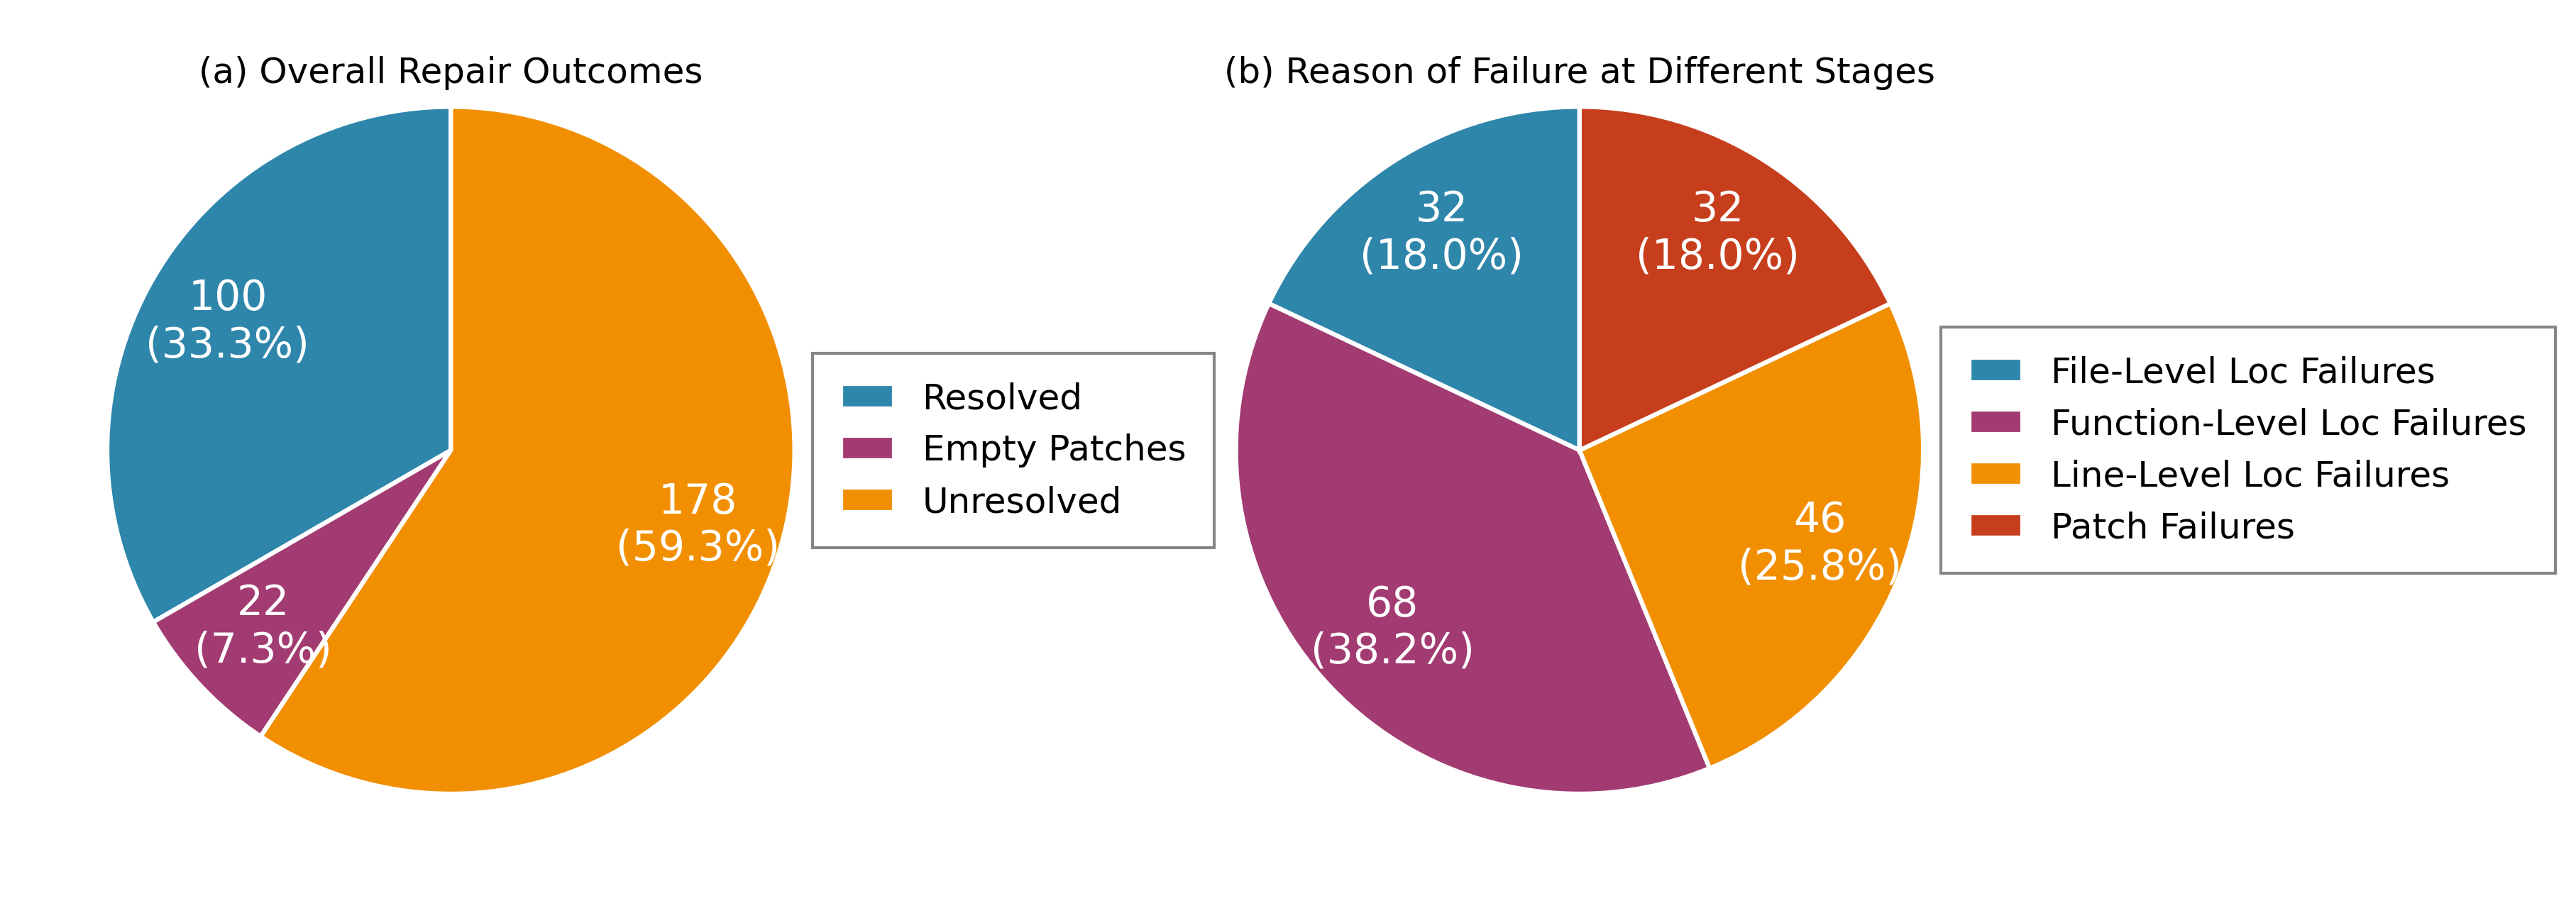

In [59]:
import matplotlib.pyplot as plt

# --- Data ---
overall_repair_stages_dict = {
    "Resolved": len(ragfix_prediction_data["resolved_ids"]),
    "Empty Patches": len(empty_patches),
    "Unresolved": total_unresolved,
}

failure_stages_dict_when_localization_was_correct = {
    "File-Level Loc Failures": could_not_localize_at_file_level,
    "Function-Level Loc Failures": total_incorrectly_predicted_instances_at_function_level,
    "Line-Level Loc Failures": total_incorrectly_predicted_instances_at_line_level,
    "Patch Failures": len(correctly_localized_at_line_level_ids),
}

# --- Professional color palette (colorblind-friendly) ---
colors = ["#2E86AB", "#A23B72", "#F18F01", "#C73E1D", "#6A994E"]

def make_pie(ax, data):
    labels = list(data.keys())
    values = list(data.values())
    total = sum(values)

    wedges, texts, autotexts = ax.pie(
        values,
        colors=colors[:len(values)],
        startangle=90,
        autopct=lambda p: f"{int(round(p * total / 100.0))}\n({p:.1f}%)" if p > 3 else "",
        pctdistance=0.75,
        textprops={"fontsize": 14, "color": "white"},
        wedgeprops={"linewidth": 1.5, "edgecolor": "white"},
    )

    ax.set(aspect="equal")

    # Legend on the right side
    ax.legend(
        wedges,
        labels,
        loc="center left",
        bbox_to_anchor=(0.9, 0.5),
        fontsize=12,
        frameon=True,
        fancybox=False,
        shadow=False,
        handlelength=1.5,
        borderpad=0.8,
        edgecolor="gray",
        facecolor="white",
        framealpha=0.95,
    )

# --- Layout ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), dpi=300)
fig.subplots_adjust(wspace=0.5, bottom=0.15, left=0.05, right=0.85)

make_pie(axes[0], overall_repair_stages_dict)
make_pie(axes[1], failure_stages_dict_when_localization_was_correct)

# --- Subplot captions (professional style) ---
axes[0].text(0, 1.1, "(a) Overall Repair Outcomes", 
             ha="center", va="center", fontsize=12)
axes[1].text(0, 1.1, "(b) Reason of Failure at Different Stages", 
             ha="center", va="center", fontsize=12)

# --- Final polish ---
plt.tight_layout()
plt.savefig("repair_outcomes.pdf", dpi=300, bbox_inches="tight")
plt.show()
